In [ ]:
# numeric packages
import numpy as np
import pandas as pd

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# compression
import gzip
import pickle
import copy

# widgets and interaction
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# numeric packages
import numpy as np
import pandas as pd

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# these magics ensure that external modules that are modified are also automatically reloaded
# %reload_ext autoreload
# %autoreload 2

In [ ]:
# outPath = "/home/data/urban-atlas/extracted-data"
outPath = "/extracted-data"

if not os.path.exists(outPath):
    os.makedirs(outPath)

In [ ]:
# locations_path = "/home/data/urban-atlas/extracted-data/"
locations_path = "/extracted-data/"

grid_location_files = glob.glob("%s/*/sample_locations_raster_25km.csv"%locations_path)
grid_location_files = {f.split("/")[-2]:f for f in grid_location_files}

more_location_files = glob.glob("%s/*/additional_sample_locations.csv"%locations_path)
more_location_files = {f.split("/")[-2]:f for f in more_location_files}

In [ ]:
def load_locations(path="./"):
    '''
    This function loads csv files for which each line contains information on the
    location of an image to be acquired from Google Maps.
    '''


    # Load the CSV files
    # grid_locations_df = pd.read_csv(path + "/sample_locations_raster_25km.csv")
    # more_locations_df = pd.read_csv(path + "/additional_sample_locations25km.csv")

    grid_locations_df = pd.read_csv("sample_locations_raster_25km.csv")
    more_locations_df = pd.read_csv("additional_sample_locations25km.csv")

    # Add 'ITEM' column if it does not exist
    if 'ITEM' not in more_locations_df.columns:
        more_locations_df['ITEM'] = 'default_value'  # Use a default value or some logic to assign values

    # Now rename 'ITEM' to 'class'
    more_locations_df = more_locations_df.rename(columns={"ITEM": "class"})

    # Print the counts of samples in each dataframe
    print(f"Grid samples: {len(grid_locations_df)}. Additional samples: {len(more_locations_df)}")

    # Initialize missing columns in more_locations_df
    more_locations_df['grid-i'] = np.nan
    more_locations_df['grid-j'] = np.nan

    # Define the columns to be used
    columns = ["lon", "lat", "grid-i", "grid-j", "class"]

    # Concatenate both dataframes based on specified columns
    locations = pd.concat([grid_locations_df[columns], more_locations_df[columns]])

    # Reset the index and drop the old index column
    locations = locations.reset_index(drop=True)

    return locations

In [ ]:
import os
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\manas\Land-Classification


In [ ]:
city = "madrid-es"

# workdir = "%s-%s" % (outPath, city)

workdir = r"C:\Users\manas\Land-Classification\madrid-es"

os.chdir(workdir)

locations = load_locations()
print(len(locations))

locations.groupby("class").apply(len)

Grid samples: 7840. Additional samples: 26948
34788


class
Agricultural + Semi-natural areas + Wetlands                     4247
Construction sites                                                 62
Continuous Urban Fabric (S.L. > 80%)                              152
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)              129
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)         153
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)      205
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)           29
Fast transit roads and associated land                             30
Forests                                                           114
Green urban areas                                                 353
Industrial, commercial, public, military and private units        167
Mineral extraction and dump sites                                   4
Other roads and associated land                                  2074
Railways and associated land                                       18
Sports and lei

In [ ]:
import sys
print(sys.path)

['C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310', 'c:\\Users\\manas\\Land-Classification\\.venv', '', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages\\win32', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages\\Pythonwin']


In [ ]:
import sys
print(sys.path)  # To see what directories Python is searching for modules

# To see if the pysatapi module can be found in any of these directories
import pysatapi
print(pysatapi.__file__)  # This will print the path to the __init__.py file of the first pysatapi


['C:\\Users\\manas\\Land-Classification\\pysatapi', 'C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\manas\\AppData\\Local\\Programs\\Python\\Python310', 'c:\\Users\\manas\\Land-Classification\\.venv', '', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages\\win32', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\manas\\Land-Classification\\.venv\\lib\\site-packages\\Pythonwin']
C:\Users\manas\Land-Classification\pysatapi\pysatapi\__init__.py


In [ ]:
import sys
# Adding the directory that contains the GoogleMaps.py file to the Python path
sys.path.insert(0, 'C:\\Users\\manas\\Land-Classification\\pysatapi')


In [ ]:
from GoogleMaps import GoogleMaps

In [30]:
import os
googleAPIKey = os.environ.get('GOOGLE_API_KEY')
gmClient = GoogleMaps(key=googleAPIKey)

MAX_REQUESTS = 35000
MAX_TRIES    = 2
img_size     = 224
ZOOM         = 17

Extract data for a given city

In [ ]:
cities = ["madrid"]

In [ ]:
def sanitize_filename(filename):
    invalid_chars = '<>:"/\\|?*'
    for char in invalid_chars:
        filename = filename.replace(char, '')  # Replace each invalid character with an empty string
    return filename

In [ ]:
def download_images(locations, prefix="", out_path="./"):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    global n_requests

    for i,r in locations.iterrows():
        clear_output(wait=True)
        print("Pulling image %d/%d... (# API requests = %d)"%(i,len(locations), n_requests))

        # Sanitize the filename to remove special characters in the filename
        label = sanitize_filename(r['class'])
        lat, lon, grid_i, grid_j = r['lat'], r['lon'], r['grid-i'], r['grid-j']

        # basename = "%s/%s/%s_z%d_%2.5f_%2.5f"%(out_path, label, prefix, ZOOM, lat, lon)
        # basename = "%s/%s_z%d_%2.5f_%2.5f"%(label, prefix, ZOOM, lat, lon)
        # if not np.isnan(grid_i) and not np.isnan(grid_j):
        #     cur_filename = "%s_grid-i%d_grid-j%d.jpg"%(basename, grid_i, grid_j)
        # else:
        #     cur_filename = "%s.jpg"%basename

        basename = f"{out_path}/{label}/{prefix}_z{ZOOM}_{lat:.5f}_{lon:.5f}"
        if not np.isnan(grid_i) and not np.isnan(grid_j):
            cur_filename = f"{basename}_grid-i{int(grid_i)}_grid-j{int(grid_j)}.jpg"
        else:
            cur_filename = f"{basename}.jpg"

        print("The current_filename is: ", cur_filename)

        if os.path.exists(cur_filename):
            continue

        req = gmClient.construct_static_url((lat,lon), maptype="satellite", zoom=ZOOM, \
                                            imgsize=(int(img_size*1.18), int(img_size*1.18)))
        img = gmClient.get_static_map_image(req, filename=cur_filename, \
                                            max_tries=MAX_TRIES,\
                                            crop=True)

        if img is None or n_requests >= MAX_REQUESTS:
            print("API requests quota exceeded!")
            break
        n_requests += 1

        # display samples every now and then
        if i % 100 == 0:
            plt.imshow(img)
            plt.title("image %d (label = %s)"%(i,label))
            plt.show()
            time.sleep(5)

In [19]:
n_requests = 0

In [20]:
import os
print(os.getcwd())

C:\Users\manas\Land-Classification\madrid-es


In [26]:
# path to save data

extraction_path = "/home/data/urban-atlas/imagery/"
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# download data for a given city

out_path = r"C:\Users\manas\Land-Classification\savedImages\madrid-es-images"

# Ensure the directory exists
if not os.path.exists(out_path):
    os.makedirs(out_path)
    print(f"Directory created: {out_path}")
else:
    print(f"Directory already exists: {out_path}")

city = "madrid-es"

locations = load_locations("%s" % city)

print("The locations: ", locations[:2])

download_images(locations, prefix=city.replace(" ","-"), out_path=out_path)

Pulling image 20266/34788... (# API requests = 24995)
The current_filename is:  C:\Users\manas\Land-Classification\savedImages\madrid-es-images/default_value/madrid-es_z17_40.61427_-3.71293.jpg
Response:  <Response [403]>
Error! Trying again (1/2) in 5 sec
Response:  <Response [403]>
Error! Trying again (2/2) in 5 sec
API requests quota exceeded!


In [27]:
n_requests

24995

In [29]:
def plot_examples(images, labels, classes=None, \
                  nExamples=10, thumbSize = (50,50), title="example"):
    # build example canvass 
    from skimage.transform import resize
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.zeros((thumbSize[0]*nClusters, nExamples*thumbSize[1], 3))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = images[idx[j],:,:,:3]
            img = resize(img, thumbSize)
            canvas[i*thumbSize[0]:(i+1)*thumbSize[0], j*thumbSize[1]:(j+1)*thumbSize[1]] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print(canvas.shape)
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

In [34]:
# img_dir = extraction_path + "/budapest, hu/"
img_dir = r"C:\Users\manas\Land-Classification\savedImages\madrid-es-images"

import glob

# Adjusting the glob pattern to windows
files = np.array(glob.glob(img_dir + "\\*\\*.jpg"))  # Assuming images are categorized in subfolders by class

# files = np.array(glob.glob(img_dir + "/*/*.jpg"))

files_df = pd.DataFrame(files, columns=["filename"])
files_df['class'] = files_df['filename'].apply(lambda x: x.split("\\")[-2])
files_df['city'] = "madrid-es"  # Static, as all images pertain to Madrid

print(files_df.head())

# files_df =  pd.DataFrame(files).rename(columns={0:"filename"})
# files_df['class'] = files_df['filename'].apply(lambda x: x.split("/")[-2])
# files_df['city'] = files_df['filename'].apply(lambda x: x.split("\\")[-3])

# files_df.head()

                                            filename  \
0  C:\Users\manas\Land-Classification\savedImages...   
1  C:\Users\manas\Land-Classification\savedImages...   
2  C:\Users\manas\Land-Classification\savedImages...   
3  C:\Users\manas\Land-Classification\savedImages...   
4  C:\Users\manas\Land-Classification\savedImages...   

                                          class       city  
0  Agricultural + Semi-natural areas + Wetlands  madrid-es  
1  Agricultural + Semi-natural areas + Wetlands  madrid-es  
2  Agricultural + Semi-natural areas + Wetlands  madrid-es  
3  Agricultural + Semi-natural areas + Wetlands  madrid-es  
4  Agricultural + Semi-natural areas + Wetlands  madrid-es  


In [45]:
import re
import abbreviate

# Initialize the Abbreviate instance
abbr = abbreviate.Abbreviate()

def split_str(s, target_len=12):
    # Remove unwanted characters except alphanumeric, spaces, and %
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    
    # Split the string into words
    words = s.split(" ")
    
    # Abbreviate each word and capitalize it, if abbreviation is possible
    words = [abbr.abbreviate(w, target_len=target_len).capitalize() if abbr.abbreviate(w, target_len=target_len) else w.capitalize() for w in words]
    
    # If only one word, return it as is (add a newline if needed)
    if len(words) == 1:
        return s  # "\n" can be appended if a new line is required after a single word
    
    # If more than four words, keep the first three and the last one
    if len(words) > 4:
        words = words[:3] + [words[-1]]
    else:
        # If four or fewer words, keep them all
        words = words[:4]
    
    # Calculate the midpoint and ensure it's an integer
    midpoint = len(words) // 2  # Using integer division
    
    # Join the words into two lines split at the midpoint
    return " ".join(words[:midpoint]) + "\n" + " ".join(words[midpoint:])


In [41]:
group_sizes = files_df.groupby("class").size()
print(group_sizes)

class
Agricultural + Semi-natural areas + Wetlands                    4247
Construction sites                                                62
Continuous Urban Fabric (S.L.  80%)                              152
Discontinuous Dense Urban Fabric (S.L.  50% -  80%)              129
Discontinuous Low Density Urban Fabric (S.L.  10% - 30%)         153
Discontinuous Medium Density Urban Fabric (S.L.  30% - 50%)      205
Discontinuous Very Low Density Urban Fabric (S.L.  10%)           29
Fast transit roads and associated land                            30
Forests                                                          114
Green urban areas                                                353
Industrial, commercial, public, military and private units       167
Mineral extraction and dump sites                                  4
Other roads and associated land                                 2074
Railways and associated land                                      18
Sports and leisure facilitie

In [47]:
n_samples = 10

# sel_df = files_df.groupby("class").apply(lambda x: x.sample(n_samples))

sel_df = files_df.groupby("class").apply(lambda x: x.sample(n_samples, replace=True))


from skimage.io import imread
images = np.array(sel_df['filename'].apply(imread).values.tolist())
labels = sel_df['class'].apply(split_str)

(850, 500, 3)


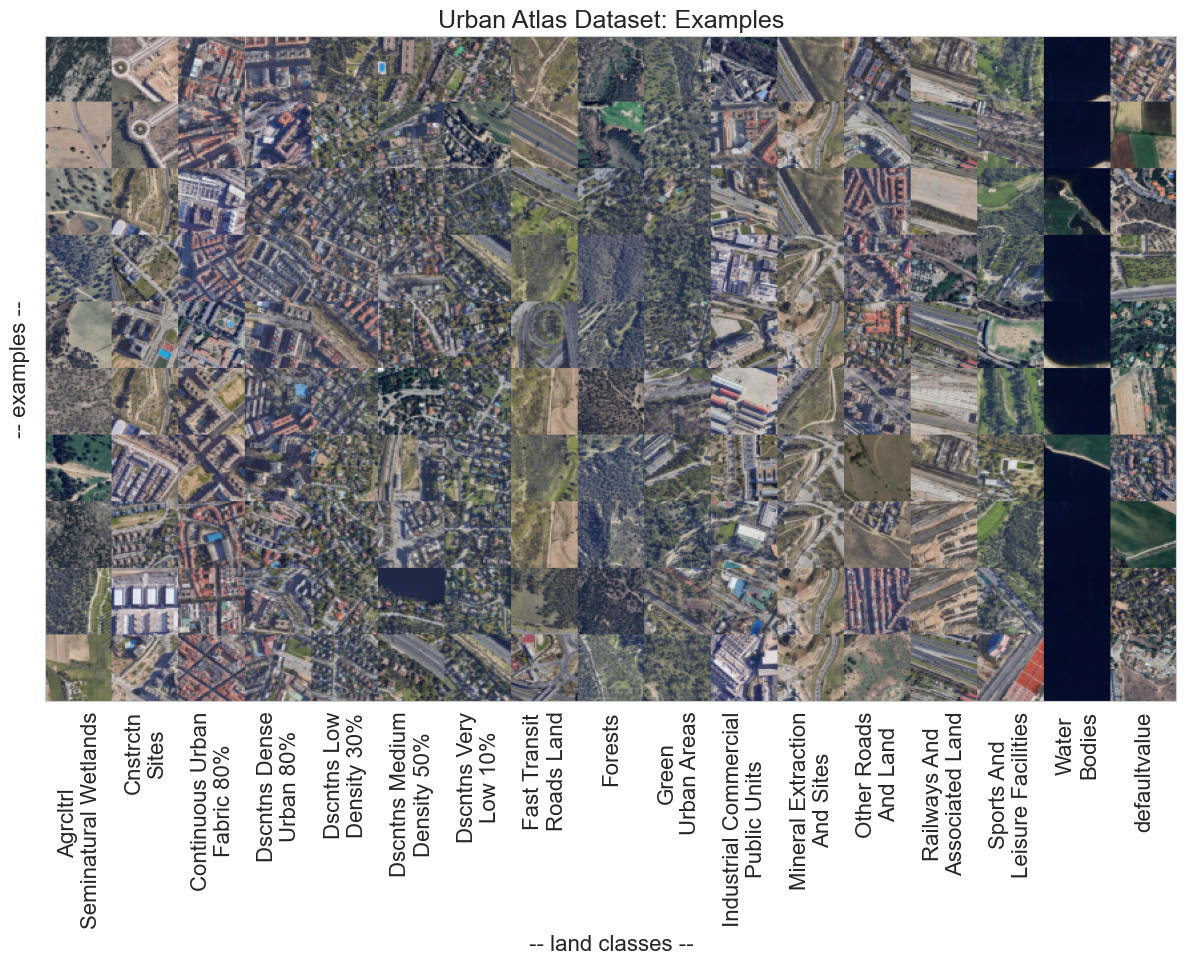

In [49]:
plot_examples(images, labels, nExamples=10, thumbSize = (50,50), title="Urban Atlas Dataset: Examples")